## 2-Sample density plot
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd
import random
import statsmodels.stats.power as smp

power = 0.851


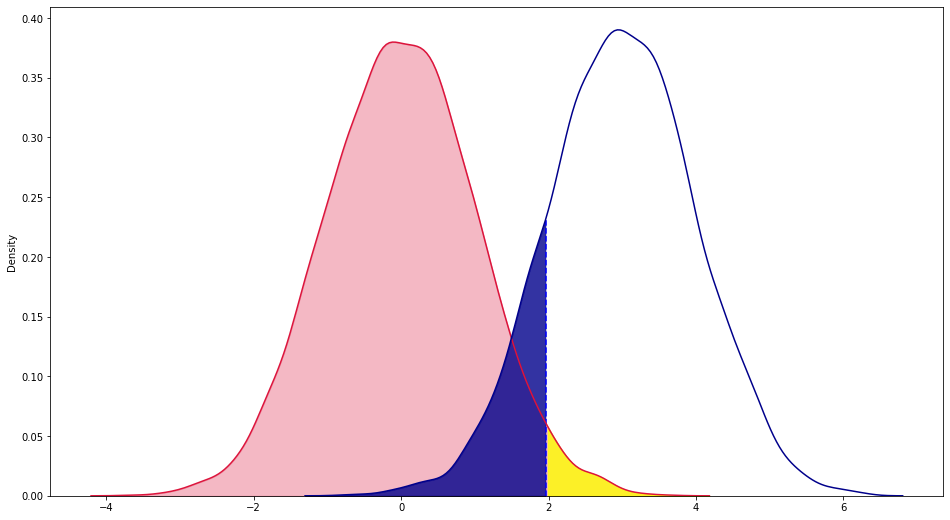

In [1]:


ua = 0
sa = 1
a = np.random.normal(ua, sa, 5000)

ub = 3
sb = 1
b = np.random.normal(ub, sb, 5000)

fig, ax = plt.subplots(figsize=(16, 9))

sns.kdeplot(a, ax=ax, legend=False,color="crimson")
xa = ax.lines[-1].get_xdata()
ya = ax.lines[-1].get_ydata()

x_special = scipy.stats.norm(ua,sa).ppf(0.975)
ax.fill_between(xa, 0, ya, where=xa >= xa.min(), color='crimson', alpha=0.3)

sns.kdeplot(b, ax=ax, legend=False, color = 'darkblue')
xb = ax.lines[-1].get_xdata()
yb = ax.lines[-1].get_ydata()




ax.vlines(x_special, 0, np.interp(x_special, xb, yb), linestyle='--', color='blue', alpha=1)

ax.fill_between(xb, 0, yb, where=xb <= x_special, color='darkblue', alpha=0.8)
ax.fill_between(xa, 0, ya, where=xa >= x_special, color='yellow', alpha=0.8)

beta = scipy.stats.norm(ub,sb).cdf(x_special)

print('power = {}'.format(round(1 - beta,3)))

plt.show()

In [2]:
(scipy.stats.norm(ub,sb).ppf(beta) - ub) / sb

-1.0400360154599457

## Pooled Variance

In [8]:
alpha = 0.05
power = 0.8

p1 = 0.0183
p2 = 0.0283


n1 = 20000
x1 = n1 * p1

n2 = 40000
x2 = n2 * p2

p_mix = (x1 + x2) / (n1 + n2)

s_mix = np.sqrt(p_mix * (1 - p_mix))

effect_size = (p2 - p1)/s_mix

ratio = n1/n2

print('p_mix = {}'.format(p_mix))
print('s_mix = {}'.format(s_mix))

print('x1 = {}, x2 = {}'.format(x1,x2))
print('Effect Size = {}\nRatio = {}'.format(effect_size, ratio))



p_mix = 0.024966666666666668
s_mix = 0.156023498942378
x1 = 366.0, x2 = 1132.0
Effect Size = 0.06409290951546447
Ratio = 0.5


In [9]:
sp = np.sqrt((p1 * (1 - p1) * (n1 - 1) + p2 * (1 - p2) * (n2 - 1))/(n1 + n2 -2))
sp

0.15595243816123006

In [10]:
np.mean([np.std( random.choices([0,1],[1-p1,p1],k=n1) + random.choices([0,1],[1-p2,p2],k=n2)) for _ in range(100)])

0.1560048183584261

## Sample Size

In [18]:
foumular_n2 = (1 + 1/ratio) * (scipy.stats.norm.ppf(1-alpha/2) + scipy.stats.norm.ppf(power))**2 / (effect_size)**2
foumular_n2 = np.int(np.ceil(foumular_n2))
foumular_n1 = np.int(np.ceil(foumular_n2 * ratio))

print('Estimated by formular\nn1 = {}\nn2 = {}'.format(foumular_n1,foumular_n2))

Estimated by formular
n1 = 2867
n2 = 5733


In [19]:
power_analysis = smp.NormalIndPower()
sampleSize = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05, alternative='two-sided', ratio = ratio)
sampleSize_n2 = np.int(np.ceil(sampleSize))
sampleSize_n1 = np.int(np.ceil(sampleSize_n2 * ratio))

print('n2 = {}, n1 = {}'.format(sampleSize_n2, sampleSize_n1))

n2 = 5733, n1 = 2867


## Power Validation

In [24]:
[int(i) for i in [sampleSize_n1*p1,sampleSize_n2*p2,sampleSize_n1*(1-p1),sampleSize_n2*(1-p2)]]

[52, 162, 2814, 5570]

In [21]:
def get_t_result(sampleSize_n1, sampleSize_n2, p1, p2):
    group1 = random.choices([0,1],[1-p1,p1],k=sampleSize_n1)
    group2 = random.choices([0,1],[1-p2,p2],k=sampleSize_n2)
    ttresult = sw.ztest(group1, group2,alternative='two-sided')
    return(ttresult[1])

In [22]:
num_runs = 10000

import statsmodels.stats.weightstats as sw

power_sim_results = pd.DataFrame({'p_value': np.zeros(num_runs)})

for run in range(num_runs):
    power_sim_results.loc[run, 'p_value'] = get_t_result(sampleSize_n1, sampleSize_n2, p1, p2)


p_reject = np.mean(power_sim_results['p_value'] < 0.05)
p_reject

0.8118

In [57]:
np.random.seed(202110)

num_runs = 1000

alpha = 0.05
power = 0.8

p1 = 0.60
p2 = 0.682


# n1 = 1000
# x1 = n1 * p1

# n2 = 1000
# x2 = n2 * p2



s0 = np.sqrt(0.46)
s1 = s0


effect_size = (p2 - p1)/s0

# ci_n = 2 * (1.96/effect_size)**2
# print('95% Confidence Interval Sample = {}'.format(ci_n))

# perform power analysis to get sample size TTestIndPower
# power_analysis = smp.TTestIndPower()
# sampleSize = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha,alternative='two-sided')
sampleSize = 548 * 2

# round up from estimated sample size
sampleSize = np.int(np.ceil(sampleSize))

print("Sample Size for each group = {}".format(sampleSize))


# create a function that will generate samples and test for
# a difference between groups using a two-sample t-test


def get_t_result(sampleSize, p1, p2, s0, s1):
    """
    perform a ttest on random data of n=sampSize
    """

    group1 = np.random.normal(loc=p1, scale=s0, size=sampleSize)
    group2 = np.random.normal(loc=p2, scale=s1, size=sampleSize)
    ttresult = scipy.stats.ttest_ind(group1, group2,alternative='two-sided')
    return(ttresult.pvalue)


# create input data frame for output
power_sim_results = pd.DataFrame({'p_value': np.zeros(num_runs)})

for run in range(num_runs):
    power_sim_results.loc[run, 'p_value'] = get_t_result(sampleSize, p1, p2, s0, s1)


p_reject = np.mean(power_sim_results['p_value'] < 0.05)
p_reject

Sample Size for each group = 1096


0.791

## Alpha, Power and AUC
+ $\alpha$ = 0.05
+ $1 - \beta$ = 0.8
+ AUC = ?

power = 0.851
alpha/2 = 0.025


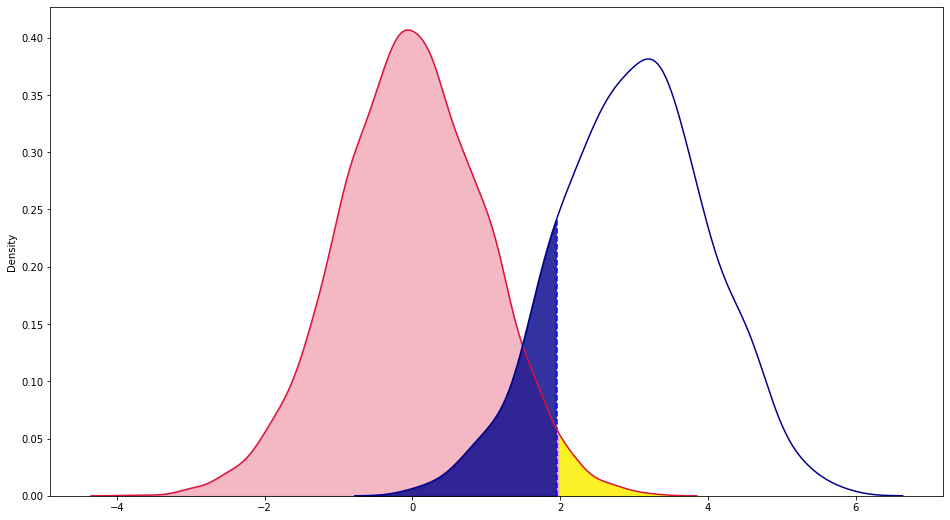

In [29]:

ua = 0
sa = 1
a = [round(i,3) for i in np.random.normal(ua, sa, 5000)]

ub = 3
sb = 1
b = [round(i,3) for i in np.random.normal(ub, sb, 500)]

fig, ax = plt.subplots(figsize=(16, 9))

sns.kdeplot(a, ax=ax, legend=False,color="crimson")
xa = ax.lines[-1].get_xdata()
ya = ax.lines[-1].get_ydata()

x_special = scipy.stats.norm(ua,sa).ppf(0.975)
ax.fill_between(xa, 0, ya, where=xa >= xa.min(), color='crimson', alpha=0.3)

sns.kdeplot(b, ax=ax, legend=False, color = 'darkblue')
xb = ax.lines[-1].get_xdata()
yb = ax.lines[-1].get_ydata()




ax.vlines(x_special, 0, np.interp(x_special, xb, yb), linestyle='--', color='blue', alpha=1)

ax.fill_between(xb, 0, yb, where=xb <= x_special, color='darkblue', alpha=0.8)
ax.fill_between(xa, 0, ya, where=xa >= x_special, color='yellow', alpha=0.8)

beta = scipy.stats.norm(ub,sb).cdf(x_special)
alpha = 1 - scipy.stats.norm(ua,sa).cdf(x_special)

print('power = {}\nalpha/2 = {}'.format(round(1 - beta,3),round(alpha,3)))

plt.show()

In [5]:
gt = 0
tie = 0
for x in a:
    for y in b:
        if y > x:
            gt = gt + 1
        elif x == y:
            tie = tie + 0.5

In [6]:
print('gt = {}\ntie = {}'.format(gt,tie))
(gt + tie)/(len(a)*len(b))

gt = 2461537
tie = 34.0


0.9846284

## Validated by Logistic Regression

In [7]:
df = np.zeros((len(a)+len(b),3))

In [8]:
df[:,0] = np.ones(len(b) + len(a))
df[:,1] = np.concatenate((a,b))
df[:,2] = np.concatenate((np.zeros(len(a)),np.ones(len(b))))
df

In [10]:
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm

In [11]:
logr = sm.Logit(df[:,2], df[:,:2])
logr = logr.fit(disp=0)
preds = logr.predict(df[:,:2])
auc = roc_auc_score(df[:,2],preds)  
print('Train_AUC=',round(auc,5))


Train_AUC= 0.98463


## Min Detectable Effect Size

In [4]:

import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [3]:
def generate_dataset(n_samples=100, uplift=0):
    x = np.random.uniform(low=0, high=1, size=n_samples*2)
    y = (
        + 10 * np.abs(x - 0.25)  
        + 2 * np.sin((x * 5) * 2 * np.pi)
        + np.random.normal(size=n_samples*2)
    )
    
    assignment = [1] * n_samples + [0] * n_samples
    np.random.shuffle(assignment)
    
    samples = pd.DataFrame({
        "x": x,
        "y": y,
        "group": assignment
    })
    
    samples.loc[lambda df: df.group == 1, "y"] += uplift
    
    return samples

In [32]:
ds = generate_dataset(n_samples=1000, uplift=1)
ds.head()

,x,y,group
0,0.239820,3.716634,1
1,0.419478,2.931782,0
2,0.015549,2.943087,1
3,0.703340,5.743359,1
4,0.881643,7.219369,1


<AxesSubplot:xlabel='y', ylabel='Density'>

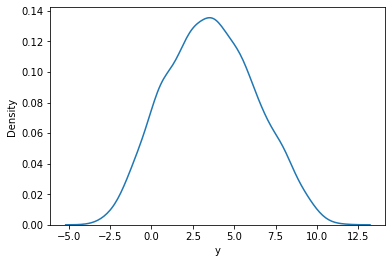

In [33]:
sns.kdeplot(ds.y)

In [34]:
from scipy.stats import norm

sample_size = 1000
alpha = 0.05
z = norm.isf(alpha / 2)
estimated_variance = ds.y.var()

detectable_effect_size = z * np.sqrt(2 * estimated_variance / sample_size)
detectable_effect_size

0.23650190043391897

Points with significant effect: 10/20
Points whose confidence interval do not covers the true effect size: 1/20


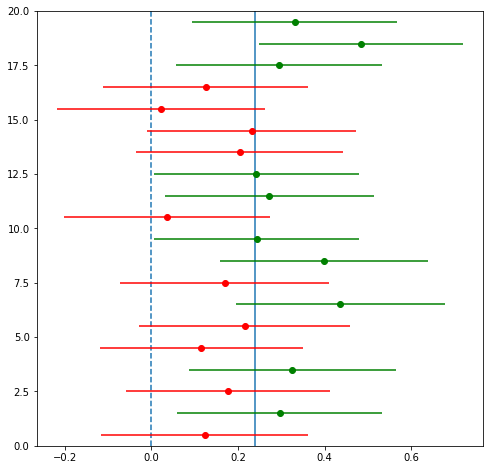

In [44]:
from scipy.stats import ttest_ind

n_experiments = 20
uplift = 0.24
sample_size = 1000
alpha = 0.05
z = norm.isf(alpha / 2)

results = []
is_significant = []

# run some experiments
for _ in range(n_experiments):
    ds = generate_dataset(n_samples=sample_size,uplift=uplift)
    base = ds[ds.group == 0]
    variant = ds[ds.group == 1]
    
    # estimated effect size is just the difference in means
    estimated_effect_size = variant.y.mean() - base.y.mean()
    
    # estiamated error is the combined variance of each group
    estimated_effect_err = 2 * np.sqrt(
        variant.y.var()/variant.shape[0] + 
        base.y.var() / base.shape[0]
    )
    results.append((estimated_effect_size, estimated_effect_err))
    
    # t-test to check if significant
    t,p = ttest_ind(base.y.values, variant.y.values)
    is_significant.append(p <= 0.05)
    
    
# plot everything
y = np.arange(n_experiments) + 0.5
x = np.asarray([i[0] for i in results])
xerr = np.asarray([i[1] for i in results])
is_significant = np.array(is_significant)

plt.figure(figsize=(8,8))
plt.vlines(0, 0, len(results), linestyles="dashed")
plt.vlines(uplift, 0, len(results))
plt.ylim(0,len(results))

mask = is_significant
plt.errorbar(x[mask],y[mask],xerr=xerr[mask], ls="none", c="g", marker="o")
mask = ~mask
plt.errorbar(x[mask],y[mask],xerr=xerr[mask], ls="none", c="r", marker="o");

print("Points with significant effect: {}/{}".format(np.sum(mask), n_experiments))
print("Points whose confidence interval do not covers the true effect size: {}/{}".format(
    np.sum(np.abs(x-uplift) > xerr), n_experiments))

## Variance Reduction by Machine Learning

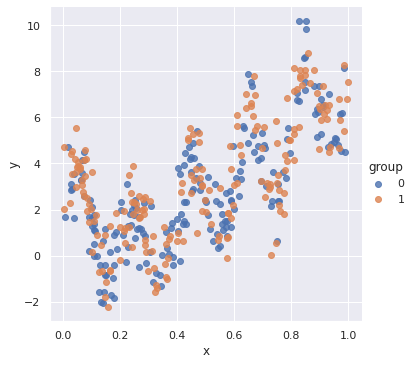

In [10]:
ds = generate_dataset(n_samples=200)
sns.lmplot(data=ds, x="x", y="y", hue="group", fit_reg=False)

In [11]:
correlation = ds.corr().loc["x","y"]
correlation

0.6375920658995928

In [12]:
def run_many_times(dataset_generator, estimator, n_runs):
    return np.array([estimator(dataset_generator()) for _ in range(n_runs)])

def compare_estimators(dataset_generator, estimators, true_uplift, n_runs=500):
    results = {}
    
    for estimator_name, estimator in estimators.items():
        res = run_many_times(dataset_generator, estimator, n_runs)
        sns.set(rc={'figure.figsize':(16,9)})
        sns.kdeplot(res, shade=True, label=estimator_name)
        
        print("Estimator: {}".format(estimator_name))
        print("\tConfidence Interval Width: {:.3f}".format(2 * np.std(res)))
        print("\tBias: {:.3f}".format(np.mean(res - true_uplift)))
        results[estimator_name] = res
        
    ymin, ymax = plt.ylim()
    plt.vlines(uplift, 0, ymax)
    plt.vlines(0, 0, ymax, linestyles="dashed")
    plt.ylim(0, ymax)
    
    return results

In [13]:
def base_estimator(ds):
    a = ds[ds.group == 0]
    b = ds[ds.group == 1]
    return b.y.mean() - a.y.mean()

Estimator: base
	Confidence Interval Width: 0.240
	Bias: -0.003


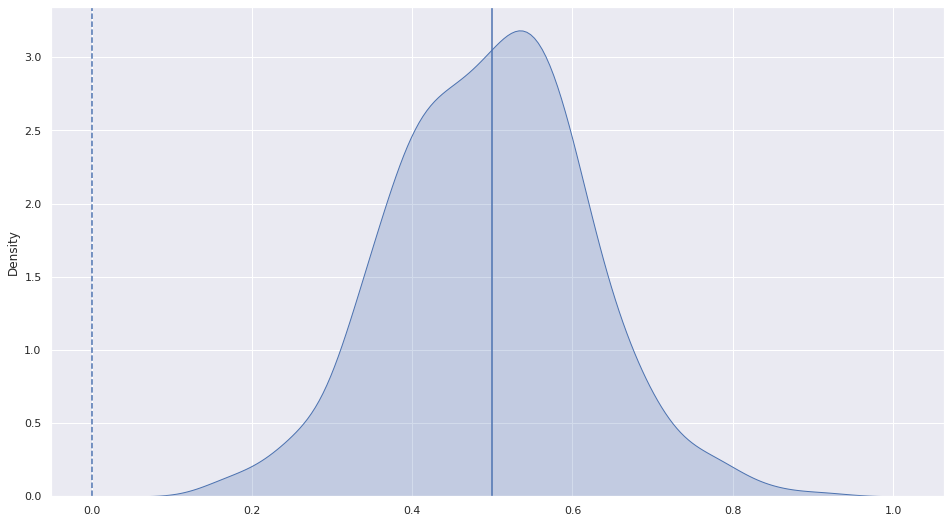

In [14]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
    },
    true_uplift=uplift
)

In [15]:
def cv_estimator(ds):
    theta = ds.cov().loc["x", "y"] / ds.cov().loc["x", "x"]
    
    ds_copy = ds.copy()
    ds_copy.y = ds.y - theta * ds.x
    
    return base_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.232
	Bias: -0.004
Estimator: control variate estimator
	Confidence Interval Width: 0.170
	Bias: -0.002


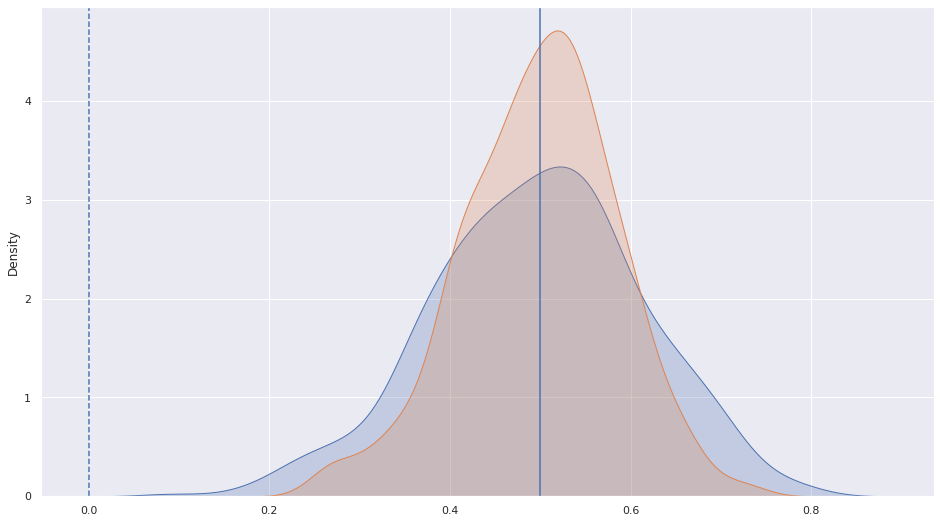

In [16]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator
    },
    true_uplift=uplift
)

In [17]:
from sklearn.ensemble import RandomForestRegressor

def rf_estimator(ds):
    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    reg = RandomForestRegressor()
    reg.fit(X,y)
    
    ds_copy = ds.copy()
    ds_copy.y = ds.y - reg.predict(X)
    
    return base_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.235
	Bias: -0.004
Estimator: control variate estimator
	Confidence Interval Width: 0.183
	Bias: -0.000
Estimator: random forest estimator
	Confidence Interval Width: 0.044
	Bias: -0.317


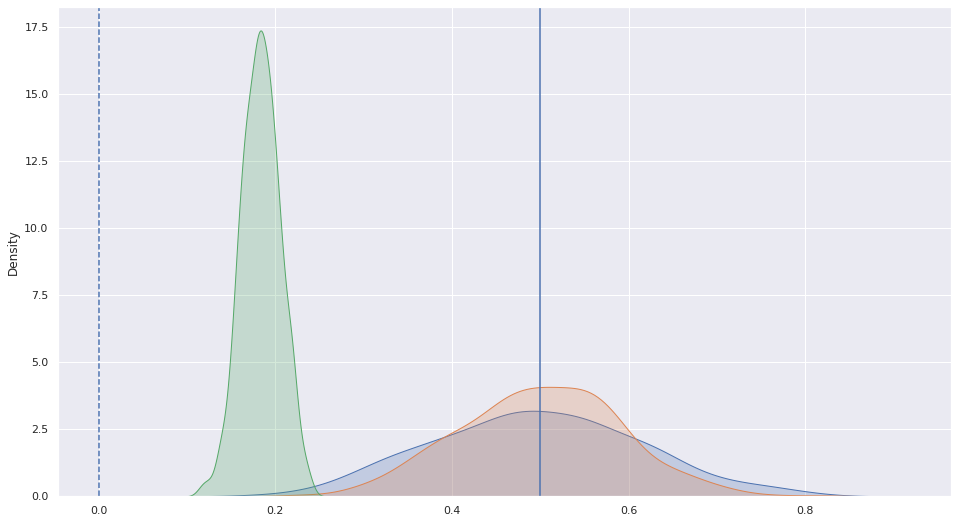

In [18]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "random forest estimator": rf_estimator
    },
    true_uplift=uplift
)

Estimator: base
	Confidence Interval Width: 5.125
	Bias: -0.092
Estimator: control_variate
	Confidence Interval Width: 6.901
	Bias: -3.357


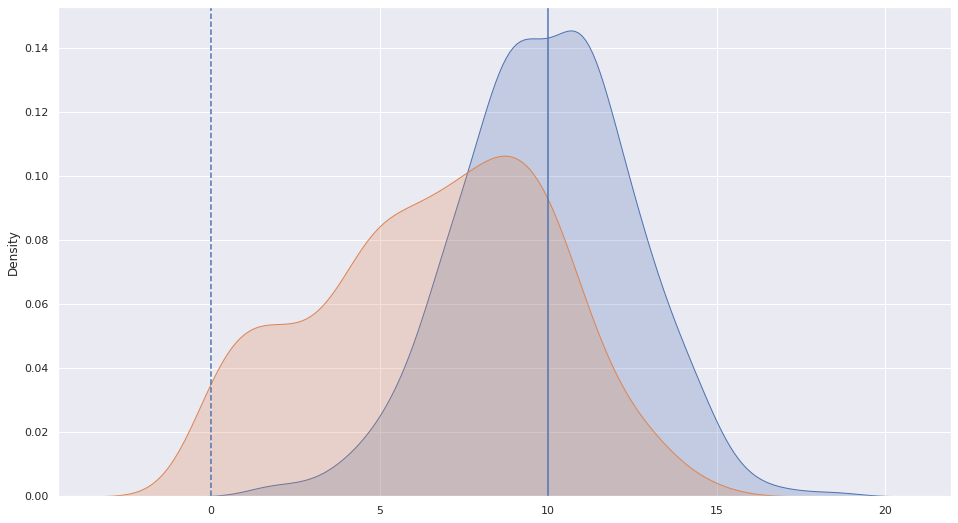

In [19]:
uplift = 10
n_samples = 2
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control_variate": cv_estimator,
    },
    true_uplift=uplift
)

In [47]:
from sklearn.model_selection import KFold

def stacked_estimator(ds):
    kfold = KFold(n_splits=5)

    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    
    reg = RandomForestRegressor()
    
    ds_copy = ds.copy()
    ds_copy["y_pred"] = 0

    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]      
        y_train, y_test = y[train_index], y[test_index]
        
        reg.fit(X_train,y_train)
        ds_copy.loc[test_index, "y_pred"] = reg.predict(X[test_index])
    
    ds_copy.y = ds_copy.y - ds_copy["y_pred"]
    
    return base_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.137
	Bias: -0.019
Estimator: control variate estimator
	Confidence Interval Width: 0.190
	Bias: 0.009
Estimator: stacked random forest estimator
	Confidence Interval Width: 0.057
	Bias: 0.006


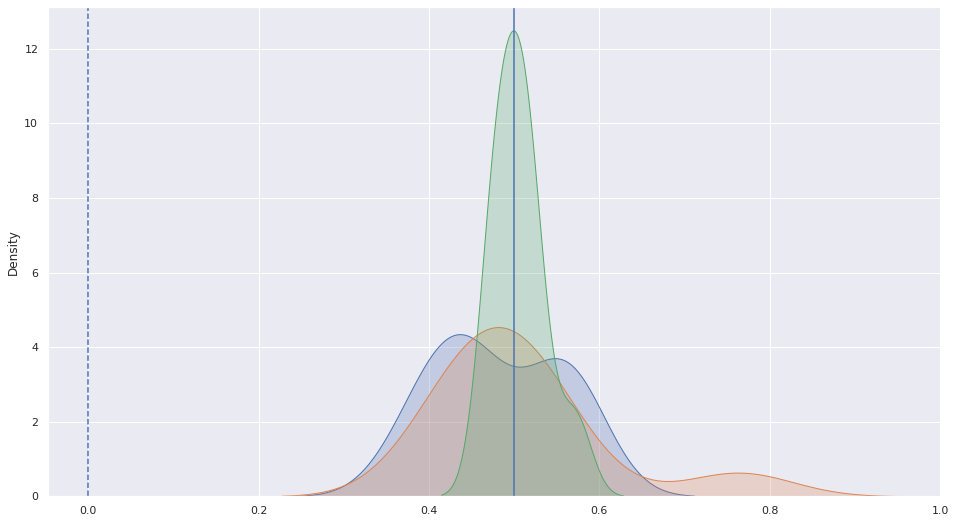

In [48]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "stacked random forest estimator": stacked_estimator
    },
    true_uplift=uplift,
    n_runs=10
)

In [49]:
from sklearn.model_selection import KFold

def stacked_cv_estimator(ds):
    kfold = KFold(n_splits=5)

    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    
    reg = RandomForestRegressor()
    
    ds_copy = ds.copy()
    ds_copy["y_pred"] = 0

    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]      
        
        y_train, y_test = y[train_index], y[test_index]
        
        reg.fit(X_train,y_train)
        ds_copy.loc[test_index, "y_pred"] = reg.predict(X[test_index])
    
    ds_copy.x = ds_copy["y_pred"]
    
    return cv_estimator(ds_copy)

Estimator: base
	Confidence Interval Width: 0.303
	Bias: 0.032
Estimator: control variate estimator
	Confidence Interval Width: 0.216
	Bias: 0.028
Estimator: stacked random forest estimator
	Confidence Interval Width: 0.127
	Bias: -0.015
Estimator: stacked random forest CV estimator
	Confidence Interval Width: 0.118
	Bias: -0.003


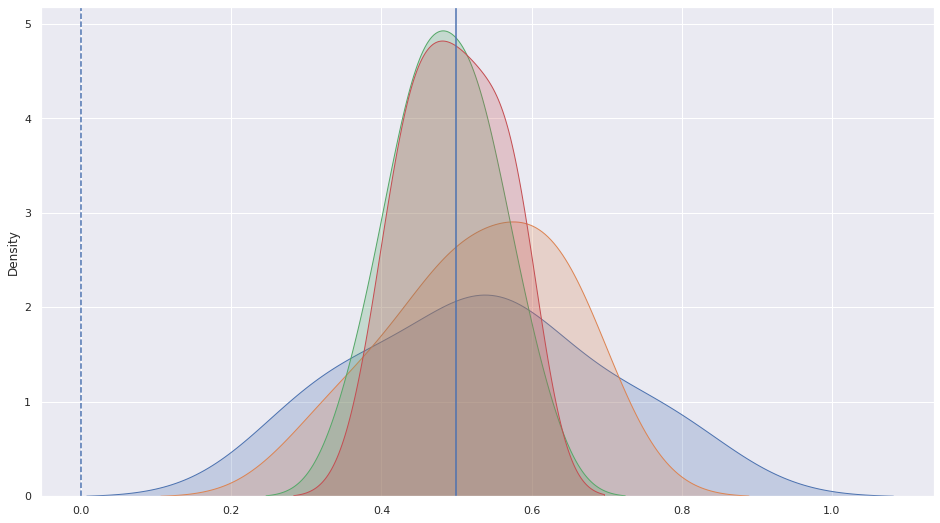

In [50]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "stacked random forest estimator": stacked_estimator,
        "stacked random forest CV estimator": stacked_cv_estimator,
    },
    true_uplift=uplift,
    n_runs=10
)